# Automatic weather station examples 
Eric Gagliano (egagli@uw.edu)   
Updated: March 7th, 2024

**Thanks for checking out these examples! The automatic_weather_station module is intended to make it easier to retrieve daily SNOTEL and CCSS data without having to do clunky downloads and conversions. Snow depth / SWE / PRCPSA are in meters, temperatures are in celsius. This module is built on my [snotel_ccss_stations](https://github.com/egagli/snotel_ccss_stations) repository, which uses a github action to auto-update the station data daily.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%aimport easysnowdata

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tqdm
import contextily as ctx

import xarray as xr
import glob

import requests 
from io import StringIO

#import logging
#logging.basicConfig(format='%(levelname)s:%(message)s',level=logging.INFO)

## View all SNOTEL & CCSS stations
- the [SNOwpack TELemetry (SNOTEL) network](https://www.nrcs.usda.gov/wps/portal/wcc/home/aboutUs/monitoringPrograms/automatedSnowMonitoring/) includes over 800 automated weather stations in the Western U.S. for mountain snowpack observation
- the [CCSS program](https://water.ca.gov/Programs/Flood-Management/Flood-Data/Snow-Surveys) manages a network of 130 automated snow sensors located in the Szierra Nevada and Shasta-Trinity Mountains

### Get an up to date GeoDataFrame of all active SNOTEL and CCSS stations

In [3]:
# bbox_gdf = gpd.read_file('https://github.com/egagli/sar_snowmelt_timing/raw/main/input/shapefiles/mt_rainier.geojson')

In [4]:
StationCollection = easysnowdata.automatic_weather_stations.StationCollection()

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.


In [5]:
StationCollection.all_stations_gdf

name network  elevation_m   latitude   longitude  \
code                                                                        
301_CA_SNTL          Adin Mtn  SNOTEL  1886.712036  41.235828 -120.791924   
907_UT_SNTL       Agua Canyon  SNOTEL  2712.719971  37.522171 -112.271179   
916_MT_SNTL        Albro Lake  SNOTEL  2529.840088  45.597229 -111.959023   
1267_AK_SNTL   Alexander Lake  SNOTEL    48.768002  61.749668 -150.889664   
908_WA_SNTL    Alpine Meadows  SNOTEL  1066.800049  47.779572 -121.698471   
...                       ...     ...          ...        ...         ...   
SLT               Slate Creek    CCSS  1737.360000  41.043980 -122.480103   
SLI              Slide Canyon    CCSS  2804.160000  38.091234 -119.431881   
SLK                South Lake    CCSS  2926.080000  37.175903 -118.562660   
STL               State Lakes    CCSS  3169.920000  36.926483 -118.573250   
TMR           Tamarack Summit    CCSS  2301.240000  37.163750 -119.200531   

                   state           HUC   mgrs  \
code                                            
301_CA_SNTL   California  180200021403  10TFL   
907_UT_SNTL         Utah  160300020301  12SUG   
916_MT_SNTL      Montana  100200050701  12TVR   
1267_AK_SNTL      Alaska  190205051106  05VPJ   
908_WA_SNTL   Washington  171100100501  10TET   
...                  ...           ...    ...   
SLT           California  180200050304  10TEL   
SLI           California  180400090501  11SKC   
SLK           California  180901020601  11SLB   
STL           California  180300100305  11SLA   
TMR           California  180400060903  11SLB   

                                mountainRange  beginDate    endDate  csvData  \
code                                                                           
301_CA_SNTL                Great Basin Ranges 1983-10-01 2100-01-01     True   
907_UT_SNTL                  Colorado Plateau 1994-10-01 2100-01-01     True   
916_MT_SNTL   Central Montana Rocky Mountains 1996-09-01 2100-01-01     True   
1267_AK_SNTL                             None 2014-08-28 2100-01-01     True   
908_WA_SNTL                     Cascade Range 1994-09-01 2100-01-01     True   
...                                       ...        ...        ...      ...   
SLT                         Klamath Mountains 2004-10-01 2024-04-01     True   
SLI                             Sierra Nevada 2005-10-01 2024-04-01     True   
SLK                             Sierra Nevada 2004-10-01 2024-04-01     True   
STL                             Sierra Nevada 2018-11-01 2024-04-01     True   
TMR                             Sierra Nevada 2011-01-01 2024-04-01     True   

                                 geometry  
code                                       
301_CA_SNTL   POINT (-120.79192 41.23583)  
907_UT_SNTL   POINT (-112.27118 37.52217)  
916_MT_SNTL   POINT (-111.95902 45.59723)  
1267_AK_SNTL  POINT (-150.88966 61.74967)  
908_WA_SNTL   POINT (-121.69847 47.77957)  
...                                   ...  
SLT           POINT (-122.48010 41.04398)  
SLI           POINT (-119.43188 38.09123)  
SLK           POINT (-118.56266 37.17590)  
STL           POINT (-118.57325 36.92648)  
TMR           POINT (-119.20053 37.16375)  

[969 rows x 13 columns]

### Use geopandas `GeoDataFrame.explore()` on the `all_stations_gdf` geodataframe to interactively view the stations 
- color by network: red is SNOTEL, blue is CCSS.

In [6]:
StationCollection.all_stations_gdf.astype(dict(beginDate=str, endDate=str)).explore(
    column="network", cmap="bwr"
)

## Get data for a singular site: *Is our winter on track with the historical record at the Paradise, WA SNOTEL station?*
- check out information about the [SNOTEL station near Mt. Rainier at Paradise, WA](https://wcc.sc.egov.usda.gov/nwcc/site?sitenum=679)
- cool plots available at the [Northwest River Forecast Center website](https://www.nwrfc.noaa.gov/snow/snowplot.cgi?AFSW1)

### Select a station code (which you can find in this interactive plot, or by other means) 
- for SNOTEL stations, this will be of the form {unique number}_{two letter state abbreviation}_SNTL (e.g. 679_WA_SNTL).   
- for CCSS stations, this will be a three letter code (e.g. BLK).   

In [7]:
ParadiseSNOTEL = easysnowdata.automatic_weather_stations.StationCollection()

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.
Only one station chosen with variables=None. Default behavior fetches all variables for this station.
Dataframe has been added to the Station object. Please use the .data_df attribute to access.


In [ ]:
ParadiseSNOTEL.get_data("679_WA_SNTL")

(46.6, 47.0)

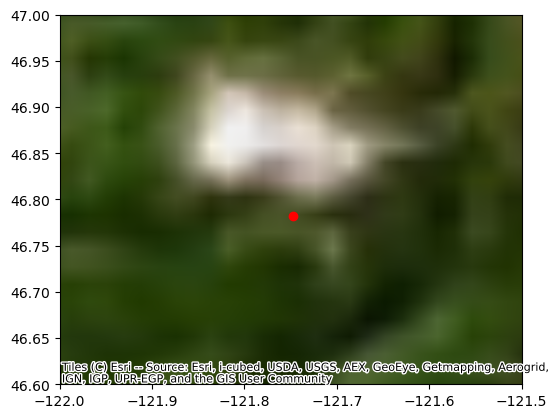

In [8]:
f, ax = plt.subplots()

ParadiseSNOTEL.stations_gdf.plot(ax=ax, color="red")

ctx.add_basemap(
    ax, crs=ParadiseSNOTEL.stations_gdf.crs, source=ctx.providers.Esri.WorldImagery
)
ax.set_xlim(-122, -121.5)
ax.set_ylim(46.6, 47)

In [9]:
ParadiseSNOTEL.data

TAVG  TMIN  TMAX    SNWD    WTEQ  PRCPSA
datetime                                            
1980-10-01   NaN   NaN   NaN     NaN  0.0000  0.0000
1980-10-02   NaN   NaN   NaN     NaN  0.0000  0.0000
1980-10-03   NaN   NaN   NaN     NaN  0.0000  0.0000
1980-10-04   NaN   NaN   NaN     NaN  0.0000  0.0000
1980-10-05   NaN   NaN   NaN     NaN  0.0000  0.0000
...          ...   ...   ...     ...     ...     ...
2024-03-27   0.1  -1.6   2.5  2.9464  1.4097  0.0279
2024-03-28  -1.0  -2.2   1.9  3.0480  1.4376  0.0102
2024-03-29   0.2  -3.5   5.7  3.1750  1.4478  0.0025
2024-03-30   1.5  -3.2   8.3  3.1242  1.4478     NaN
2024-03-31   NaN   NaN   NaN  3.1242  1.4503     NaN

[15888 rows x 6 columns]

### Try a simple plot of snow depth and SWE
- select the column of interest and use pandas built in `Series.plot()`

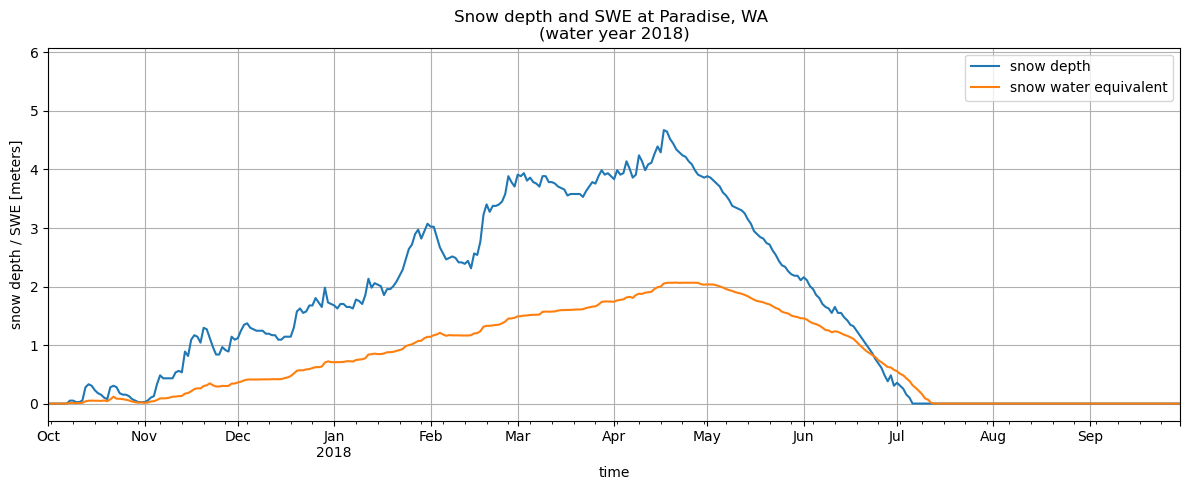

In [10]:
f, ax = plt.subplots(figsize=(12, 5))

ParadiseSNOTEL.data_df["SNWD"].plot(ax=ax, label="snow depth")
ParadiseSNOTEL.data_df["WTEQ"].plot(ax=ax, label="snow water equivalent")

ax.set_xlim(pd.to_datetime(["2017-10-01", "2018-09-30"]))

ax.grid()
ax.legend()

ax.set_xlabel("time")
ax.set_ylabel("snow depth / SWE [meters]")
ax.set_title("Snow depth and SWE at Paradise, WA \n(water year 2018)")

f.tight_layout()

### Try a more complex plot that shows current snow depth against statistics calculated from the entire time series for each day of water year
- water year is conceptual 12 month period used to describe when the bulk of precipitation falls, mostly used for hydrology attribution 
    - in the northern hemisphere, we usually define the water year to start October 1st and go until September 30th (e.g. water year 2017: October 1st, 2016 - September 30th, 2017)
    - so October 1st is DOWY 1
- try a function like `easysnowdata.utils.datetime_to_DOWY()` to convert datetimes to day of water year and add a dedicated DOWY column
    - this function should account for leap years
- then use pandas groupby functionality to calculate stats per DOWY
- plot these stats
    - thanks David Shean for the plot inspiration!

In [11]:
ParadiseSNOTEL.data_df["DOWY"] = ParadiseSNOTEL.data.index.map(
    easysnowdata.utils.datetime_to_DOWY
)
ParadiseSNOTEL.data_df["WY"] = ParadiseSNOTEL.data.index.map(
    easysnowdata.utils.datetime_to_WY
)

In [12]:
ParadiseSNOTEL.data

TAVG  TMIN  TMAX    SNWD    WTEQ  PRCPSA  DOWY    WY
datetime                                                        
1980-10-01   NaN   NaN   NaN     NaN  0.0000  0.0000     1  1981
1980-10-02   NaN   NaN   NaN     NaN  0.0000  0.0000     2  1981
1980-10-03   NaN   NaN   NaN     NaN  0.0000  0.0000     3  1981
1980-10-04   NaN   NaN   NaN     NaN  0.0000  0.0000     4  1981
1980-10-05   NaN   NaN   NaN     NaN  0.0000  0.0000     5  1981
...          ...   ...   ...     ...     ...     ...   ...   ...
2024-03-27   0.1  -1.6   2.5  2.9464  1.4097  0.0279   179  2024
2024-03-28  -1.0  -2.2   1.9  3.0480  1.4376  0.0102   180  2024
2024-03-29   0.2  -3.5   5.7  3.1750  1.4478  0.0025   181  2024
2024-03-30   1.5  -3.2   8.3  3.1242  1.4478     NaN   182  2024
2024-03-31   NaN   NaN   NaN  3.1242  1.4503     NaN   183  2024

[15888 rows x 8 columns]

In [13]:
stat_list = ["min", "max", "mean", "std", "median"]
paradise_snotel_DOWY_snwd_stats = ParadiseSNOTEL.data.groupby("DOWY").agg(stat_list)[
    "SNWD"
]
paradise_snotel_DOWY_snwd_stats

min     max      mean       std  median
DOWY                                         
1     0.0  0.2286  0.014111  0.053862     0.0
2     0.0  0.2032  0.011289  0.047895     0.0
3     0.0  0.2286  0.014111  0.053862     0.0
4     0.0  0.1270  0.012700  0.032888     0.0
5     0.0  0.1270  0.012700  0.034022     0.0
...   ...     ...       ...       ...     ...
362   0.0  0.0254  0.001411  0.005987     0.0
363   0.0  0.0254  0.001411  0.005987     0.0
364   0.0  0.0254  0.002822  0.008214     0.0
365   0.0  0.0762  0.005644  0.018595     0.0
366   0.0  0.0000  0.000000  0.000000     0.0

[366 rows x 5 columns]

In [14]:
today = datetime.datetime.today().strftime("%Y-%m-%d")
current_WY = slice(f"{int(today[0:4])-1}-10-01", f"{today}")
current_WY_paradise_snotel = ParadiseSNOTEL.data_df[current_WY.start : current_WY.stop]

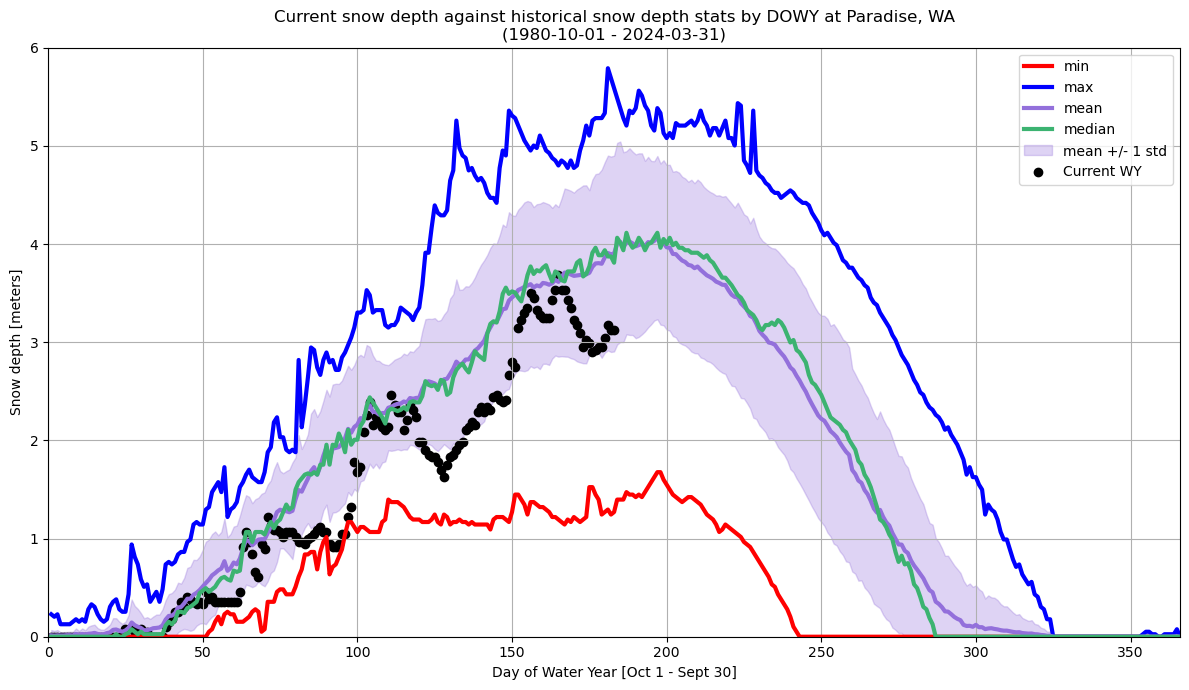

In [15]:
f, ax = plt.subplots(figsize=(12, 7))

for stat, stat_color in zip(
    ["min", "max", "mean", "median"], ["red", "blue", "mediumpurple", "mediumseagreen"]
):
    ax.plot(
        paradise_snotel_DOWY_snwd_stats.index,
        paradise_snotel_DOWY_snwd_stats[stat],
        label=stat,
        color=stat_color,
        linewidth=3,
    )

ax.fill_between(
    paradise_snotel_DOWY_snwd_stats.index,
    paradise_snotel_DOWY_snwd_stats["mean"] - paradise_snotel_DOWY_snwd_stats["std"],
    paradise_snotel_DOWY_snwd_stats["mean"] + paradise_snotel_DOWY_snwd_stats["std"],
    color="mediumpurple",
    alpha=0.3,
    label="mean +/- 1 std",
)

ax.scatter(
    current_WY_paradise_snotel.DOWY,
    current_WY_paradise_snotel.SNWD,
    marker="o",
    color="black",
    label="Current WY",
)

ax.set_xlim([0, 366])
ax.set_ylim([0, 6])

ax.grid()
ax.legend()

ax.set_title(
    f"Current snow depth against historical snow depth stats by DOWY at Paradise, WA\n({ParadiseSNOTEL.data_df.index.min().date()} - {ParadiseSNOTEL.data_df.index.max().date()})"
)
ax.set_xlabel("Day of Water Year [Oct 1 - Sept 30]")
ax.set_ylabel("Snow depth [meters]")
f.tight_layout()

**Looks like we're slightly below the mean for snow depth for today's DOWY.**

## Read a variable from a list of stations: *Does the SNOTEL network and CCSS network list the same station?*
- no controversy here, but i noticed that a station name was repeated
- perhaps both networks have data from the same station accessible
- might make sense if they are co-managed in some way?

### Create a list of the stations we are interested in and pass it in to our get_data() function

In [16]:
station_list = ["356_CA_SNTL", "BLK"]

TwoStations = easysnowdata.automatic_weather_stations.StationCollection()

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

WTEQ dataframe has been added to the Station object. Please use the .WTEQ_df attribute to access the data.
Full ['WTEQ'] dataset has been added to the station object. Please use the .data_ds attribute to access.
If you prefer to work with pandas dataframes instead of xarray datasets, please use the respective .variable_df attribute.


In [ ]:
TwoStations.get_data(station_list, variables="WTEQ")

In [17]:
TwoStations.WTEQ

356_CA_SNTL     BLK
datetime                       
1980-07-09          NaN     NaN
1980-07-10          NaN     NaN
1980-07-11          NaN     NaN
1980-07-12          NaN     NaN
1980-07-13          NaN     NaN
...                 ...     ...
2024-03-27       0.7925  0.7925
2024-03-28       0.8103  0.8103
2024-03-29       0.8204  0.8204
2024-03-30       0.8433  0.8433
2024-03-31       0.8484  0.8484

[15972 rows x 2 columns]

### Plot the two stations on the same axis
- if we properly set the index as the datetime, and we used `parse_dates=True`, these should line up!

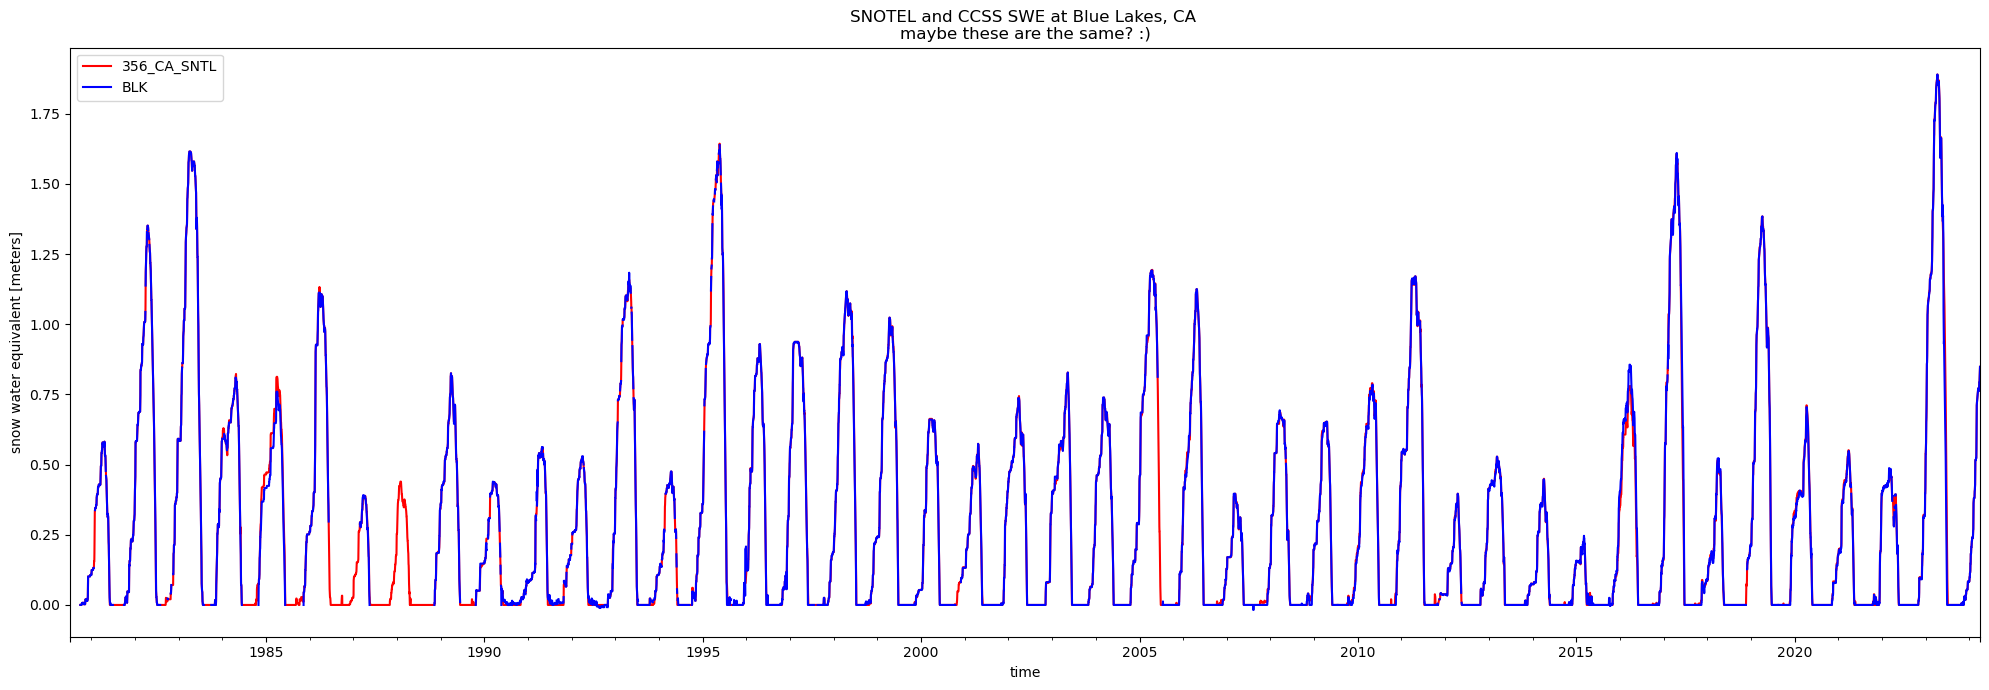

In [18]:
f, ax = plt.subplots(figsize=(20, 7))

TwoStations.WTEQ.plot(ax=ax, color=["red", "blue"])

ax.legend()

ax.set_xlabel("time")
ax.set_ylabel("snow water equivalent [meters]")
ax.set_title("SNOTEL and CCSS SWE at Blue Lakes, CA \nmaybe these are the same? :)")

f.tight_layout()

### These look oddly similar... let's check out their correlation
- convenient built in `DataFrame.corr()`

In [19]:
TwoStations.WTEQ.corr()

356_CA_SNTL       BLK
356_CA_SNTL     1.000000  0.999056
BLK             0.999056  1.000000

**These correlation values, along with the time series above, makes me think these are way too similar... no way these would agree this much even if the stations were right next to each other!**

### Let's see where they exist spatially
- select the stations by index and reproject to UTM 11N
- use `contextily` for a basemap

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


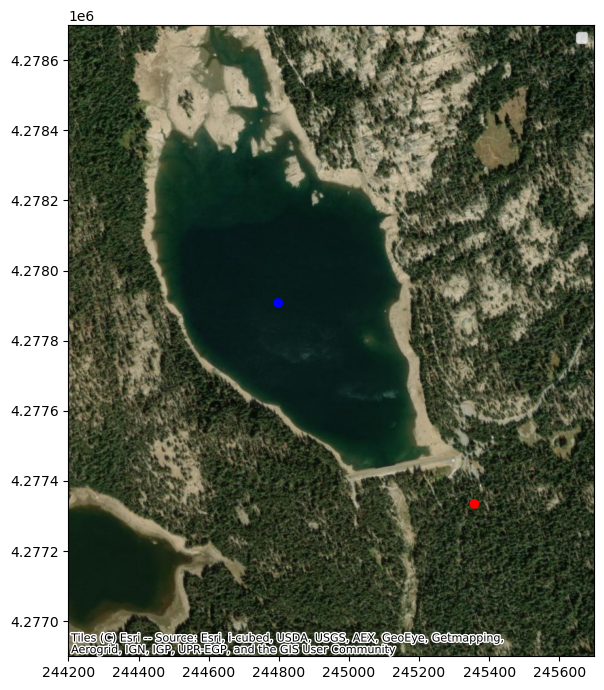

In [20]:
f, ax = plt.subplots(figsize=(7, 7))


TwoStations.stations_gdf.to_crs("EPSG:32611").plot(ax=ax, color=["red", "blue"])

ax.set_xlim([244200, 245700])
ax.set_ylim([4276900, 4278700])

ctx.add_basemap(ax, crs="EPSG:32611", source=ctx.providers.Esri.WorldImagery)

ax.legend() # add labels here

f.tight_layout()

**Interesting locations :) Based on correlation and location, I'm going to say these are the same! Wonder what those tiny differences are about...**

### Look's like some of the CCSS stations have "Natural Resources Conservation Service" as their operator
- Let's check which stations these are!
- Let's plot these shared stations in red, and not shared in blue

In [21]:
csv = 'https://cdec.water.ca.gov/misc/SnowSensors.html'
response = requests.get(csv)
same_stations_df = pd.read_html(StringIO(response.content.decode('utf-8')))[0].set_index('ID').sort_index()
same_stations_df = same_stations_df[same_stations_df.nunique(axis=1) > 1]
same_stations_gdf = gpd.GeoDataFrame(same_stations_df, geometry=gpd.points_from_xy(same_stations_df['Longitude'], same_stations_df['Latitude']))
same_stations_gdf.crs = "EPSG:4326"
same_stations_gdf = same_stations_gdf[same_stations_gdf['Operator Agency']=='Natural Resources Conservation Service']
same_stations_gdf

Name Elev (feet) Latitude Longitude  \
ID                                                            
ADM            ADIN MOUNTAIN        6200   41.237  -120.792   
BLK               BLUE LAKES        8000   38.613  -119.931   
BMW        BIG MEADOWS (SCS)        8700   39.458  -119.946   
BSK            BURNSIDE LAKE        8129   38.719  -119.894   
CDP               CEDAR PASS        7100   41.583  -120.303   
CSL     CENT SIERRA SNOW LAB        6900   39.325  -120.367   
CWF             CROWDER FLAT        5100   41.893  -120.752   
CXS              CARSON PASS        8353   38.692  -120.002   
DSS             DISMAL SWAMP        7050   41.993  -120.165   
EBB             EBBETTS PASS        8700   38.561  -119.808   
EP5              ECHO PEAK 5        7800   38.849  -120.079   
FLL         FALLEN LEAF LAKE        6250   38.932  -120.056   
HGM            HAGANS MEADOW        8000   38.853  -119.940   
HVN          HEAVENLY VALLEY        8800   38.929  -119.917   
IDC        INDEPENDENCE CAMP        7000   39.453  -120.299   
IDP  INDEPENDENCE LAKE (SCS)        8450   39.435  -120.322   
INN       INDEPENDENCE CREEK        6500   39.494  -120.293   
LBD             LOBDELL LAKE        9200   38.440  -119.377   
LVM          LEAVITT MEADOWS        7200   38.305  -119.552   
LVT             LEAVITT LAKE        9600   38.282  -119.621   
MNT             MONITOR PASS        8350   38.670  -119.615   
MRL            MARLETTE LAKE        8000   39.173  -119.905   
MSK      MOUNT ROSE SKI AREA        8900   39.326  -119.902   
PSN              POISON FLAT        7900   38.501  -119.631   
RP2           RUBICON PEAK 2        7500   39.001  -120.140   
SDW            SUMMIT MEADOW        9313   38.398  -119.536   
SPS       SONORA PASS BRIDGE        8750   38.318  -119.601   
SPT             SPRATT CREEK        6150   38.666  -119.817   
SQV  SQUAW VALLEY GOLD COAST        8200   39.194  -120.276   
TCC         TAHOE CITY CROSS        6750   39.171  -120.155   
TK2                TRUCKEE 2        6400   39.300  -120.194   
VRG     VIRGINIA LAKES RIDGE        9300   38.077  -119.234   
WC3             WARD CREEK 3        6750   39.136  -120.219   

    April 1 Avg (inches)                         Operator Agency  \
ID                                                                 
ADM                 13.6  Natural Resources Conservation Service   
BLK                 33.1  Natural Resources Conservation Service   
BMW                 25.7  Natural Resources Conservation Service   
BSK              -9999.0  Natural Resources Conservation Service   
CDP                 18.1  Natural Resources Conservation Service   
CSL                 33.6  Natural Resources Conservation Service   
CWF              -9999.0  Natural Resources Conservation Service   
CXS              -9999.0  Natural Resources Conservation Service   
DSS                 29.2  Natural Resources Conservation Service   
EBB                 38.8  Natural Resources Conservation Service   
EP5                 39.5  Natural Resources Conservation Service   
FLL                  7.0  Natural Resources Conservation Service   
HGM                 16.5  Natural Resources Conservation Service   
HVN                 28.1  Natural Resources Conservation Service   
IDC                 21.8  Natural Resources Conservation Service   
IDP                 41.4  Natural Resources Conservation Service   
INN                 12.7  Natural Resources Conservation Service   
LBD                 17.3  Natural Resources Conservation Service   
LVM                  8.0  Natural Resources Conservation Service   
LVT              -9999.0  Natural Resources Conservation Service   
MNT              -9999.0  Natural Resources Conservation Service   
MRL                 21.1  Natural Resources Conservation Service   
MSK                 38.5  Natural Resources Conservation Service   
PSN                 16.2  Natural Resources Conservation Service   
RP2                 29.1  Natural Resources Conser

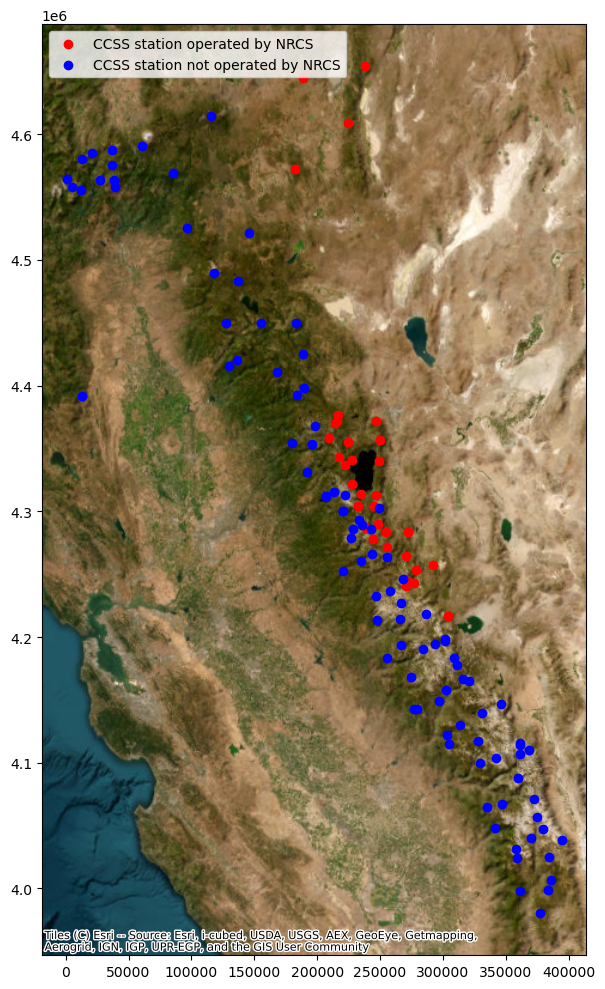

In [22]:
f, ax = plt.subplots(figsize=(10, 10))

same_stations_gdf.to_crs("EPSG:32611").plot(
    ax=ax, color="red", label="CCSS station operated by NRCS"
)
ccss_stations_gdf = TwoStations.all_stations_gdf[
    TwoStations.all_stations_gdf["network"] == "CCSS"
].to_crs("EPSG:32611")
ccss_stations_gdf[~ccss_stations_gdf.index.isin(same_stations_gdf.index)].plot(
    ax=ax, color="blue", label="CCSS station not operated by NRCS"
)

ctx.add_basemap(ax, crs="EPSG:32611", source=ctx.providers.Esri.WorldImagery)

ax.legend()

f.tight_layout()

**There are 33 of these! These are likely also listed as SNOTEL stations...**

## Read a variable using a geodataframe: *How extraordinary was the California 2023 snowpack?*
- the Sierra Nevada [received a historic amount of snow in 2023](https://www.nps.gov/articles/000/sien-sierranevadamonitor-spring2023.htm)
- let's explore the magnitude of this season by comparing to the median snow pack

### Let's bring in only CCSS stations
- Filter the all_stations_gdf with `network == CCSS`, and pass the filtered geodatframe to the get_data() function.

In [23]:
ccssStations = easysnowdata.automatic_weather_stations.StationCollection()

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.


In [24]:
ccss_only = ccssStations.all_stations_gdf[ccssStations.all_stations_gdf.network == "CCSS"]

In [26]:
ccssStations.get_data(stations=ccss_only,variables="WTEQ")

100%|██████████| 130/130 [01:08<00:00,  1.90it/s]


WTEQ dataframe has been added to the Station object. Please use the .WTEQ_df attribute to access the data.
Full ['WTEQ'] dataset has been added to the station object. Please use the .data_ds attribute to access.
If you prefer to work with pandas dataframes instead of xarray datasets, please use the respective .variable_df attribute.


In [30]:
ccssStations.WTEQ_df

FRW     BNK     CDP     CRL     CHM  HHM     HNT  MUM  SDF  \
datetime                                                                    
1909-04-13     NaN     NaN     NaN     NaN     NaN  NaN     NaN  NaN  NaN   
1954-12-01     NaN     NaN     NaN     NaN     NaN  NaN     NaN  NaN  NaN   
1954-12-02     NaN     NaN     NaN     NaN     NaN  NaN     NaN  NaN  NaN   
1954-12-03     NaN     NaN     NaN     NaN     NaN  NaN     NaN  NaN  NaN   
1954-12-04     NaN     NaN     NaN     NaN     NaN  NaN     NaN  NaN  NaN   
...            ...     ...     ...     ...     ...  ...     ...  ...  ...   
2024-03-27  0.7404  1.3106  0.5359  0.6238  0.7437  NaN  0.5418  NaN  NaN   
2024-03-28  0.7297  1.3228  0.5639  0.6388  0.7590  NaN  0.5418  NaN  NaN   
2024-03-29  0.7348  1.3320  0.5842  0.6444  0.7894  NaN  0.5502  NaN  NaN   
2024-03-30  0.7676  1.3472  0.5867  0.6548  0.8260  NaN  0.5641  NaN  NaN   
2024-03-31  0.7882  1.3594     NaN  0.6652  0.8473  NaN  0.5806  NaN  NaN   

               RTL  ...  QUA     LLP     FOR  GEM     WTM     SLT     SLI  \
datetime            ...                                                     
1909-04-13     NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN     NaN   
1954-12-01     NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN     NaN   
1954-12-02     NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN     NaN   
1954-12-03     NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN     NaN   
1954-12-04     NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN     NaN   
...            ...  ...  ...     ...     ...  ...     ...     ...     ...   
2024-03-27  0.4983  ...  NaN  2.3995  0.4359  NaN  0.5715  0.9876  0.7694   
2024-03-28  0.5105  ...  NaN  2.4514  0.4470  NaN  0.5817  0.9997  0.8016   
2024-03-29  0.5197  ...  NaN  2.4755  0.4846  NaN  0.5893  1.0119  0.8110   
2024-03-30  0.5380  ...  NaN  2.5098     NaN  NaN  0.6017  1.0363  0.8364   
2024-03-31  0.5532  ...  NaN  2.5240     NaN  NaN  0.6078  1.0516  0.8407   

               SLK     STL     TMR  
datetime                            
1909-04-13     NaN     NaN     NaN  
1954-12-01     NaN  0.0635     NaN  
1954-12-02     NaN  0.0635     NaN  
1954-12-03     NaN  0.0635     NaN  
1954-12-04     NaN  0.1143     NaN  
...            ...     ...     ...  
2024-03-27  0.3063  0.5941  0.7381  
2024-03-28  0.3094  0.6002  0.7442  
2024-03-29  0.3155  0.6106  0.7503  
2024-03-30  0.3338  0.6243  0.7777  
2024-03-31  0.3399  0.6314  0.7930  

[23109 rows x 130 columns]

### Let's check out the percent of normal snow depth for April 1st, 2023
- let's add a DOWY column to the `ccssStations.WTEQ` dataframe like before, groupby DOWY, apply a median, and divide the observation on April 1st, 2023 by the DOWY 183 (April 1) median
    - add these percent normal values back to `ccssStations.stations`
- will need to do some slight cleaning to get rid of NaNs, Infs, physically impossible values...

In [31]:
ccssStations.WTEQ_df["DOWY"] = ccssStations.WTEQ_df.index.map(
    easysnowdata.utils.datetime_to_DOWY
)
ccssStations.WTEQ_df["WY"] = ccssStations.WTEQ_df.index.map(easysnowdata.utils.datetime_to_WY)

In [32]:
ccssStations.stations_gdf.loc[:, "april2023_percent_norm"] = 100 * (
    ccssStations.WTEQ_df["2023-04-01":"2023-04-01"].squeeze()
    / ccssStations.WTEQ_df.groupby("DOWY").median().loc[183]
)

/home/eric/miniconda3/envs/easysnowdata/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [33]:
ccssStations.stations_gdf = ccssStations.stations_gdf.dropna(subset="april2023_percent_norm")
ccssStations.stations_gdf = ccssStations.stations_gdf[
    ccssStations.stations_gdf["april2023_percent_norm"] < 7500
]

### View the values in order...
- use `.sort_values()` function to get an idea of percent normal snow depth values
- `DataFrame.head()` and `DataFrame.tail()` to see highest and lowest percent normal snow depth values

In [34]:
ccssStations.stations_gdf.sort_values("april2023_percent_norm", ascending=False).head()

name network  elevation_m   latitude   longitude  \
code                                                                     
FLL       Fallen Leaf Lake    CCSS    1905.0000  38.932000 -120.056000   
LVM        Leavitt Meadows    CCSS    2194.5600  38.305000 -119.552000   
GNF   Giant Forest (Usace)    CCSS    1950.7200  36.562867 -118.770283   
TUN   Tunnel Guard Station    CCSS    2712.7200  36.366349 -118.289116   
DPO        Devils Postpile    CCSS    2307.0312  37.629410 -119.084671   

           state           HUC   mgrs  mountainRange  beginDate    endDate  \
code                                                                         
FLL   California  160501010401  10SGJ           None 2004-10-01 2024-04-01   
LVM   California  160503020104  11SKC  Sierra Nevada 2004-10-01 2024-04-01   
GNF   California  180300070402  11SLA  Sierra Nevada        NaT        NaT   
TUN   California  180300020101  11SLA  Sierra Nevada 2022-12-01 2024-04-01   
DPO   California  180400060402  11SLB  Sierra Nevada 2007-10-01 2024-04-01   

      csvData                     geometry  april2023_percent_norm  
code                                                                
FLL      True  POINT (-120.05600 38.93200)             4525.764192  
LVM      True  POINT (-119.55200 38.30500)              706.728704  
GNF      True  POINT (-118.77028 36.56287)              700.401606  
TUN      True  POINT (-118.28912 36.36635)              646.085011  
DPO      True  POINT (-119.08467 37.62941)              642.842557

In [35]:
ccssStations.stations_gdf.sort_values("april2023_percent_norm", ascending=False).tail()

name network  elevation_m   latitude   longitude  \
code                                                                       
HYS                  Huysink    CCSS    2011.6800  39.281422 -120.529633   
SQV   Palisades Tahoe Snotel    CCSS    2499.3600  39.194000 -120.276000   
DSS             Dismal Swamp    CCSS    2148.8400  41.993000 -120.165000   
LLP        Lower Lassen Peak    CCSS    2541.4224  40.466602 -121.508110   
SHM              Shimmy Lake    CCSS    1950.7200  41.005299 -122.801598   

           state           HUC   mgrs       mountainRange  beginDate  \
code                                                                   
HYS   California  180201280103  10SGJ       Sierra Nevada 2006-10-01   
SQV   California  160501020202  10SGJ       Sierra Nevada 2004-10-01   
DSS   California  171200070304  10TGM  Great Basin Ranges        NaT   
LLP   California  180201560301  10TFK       Cascade Range 2004-10-01   
SHM   California  180102110501  10TEL   Klamath Mountains 2005-10-01   

        endDate  csvData                     geometry  april2023_percent_norm  
code                                                                           
HYS  2024-04-01     True  POINT (-120.52963 39.28142)              165.648176  
SQV  2024-04-01     True  POINT (-120.27600 39.19400)              165.202219  
DSS         NaT     True  POINT (-120.16500 41.99300)              148.136711  
LLP  2024-04-01     True  POINT (-121.50811 40.46660)              146.590403  
SHM  2024-04-01     True  POINT (-122.80160 41.00530)              123.362639

### Plot the percent of normal snow depths for April 1st, 2023
- add elevation plot to the right with horizontal dashed line at 100% (normal)

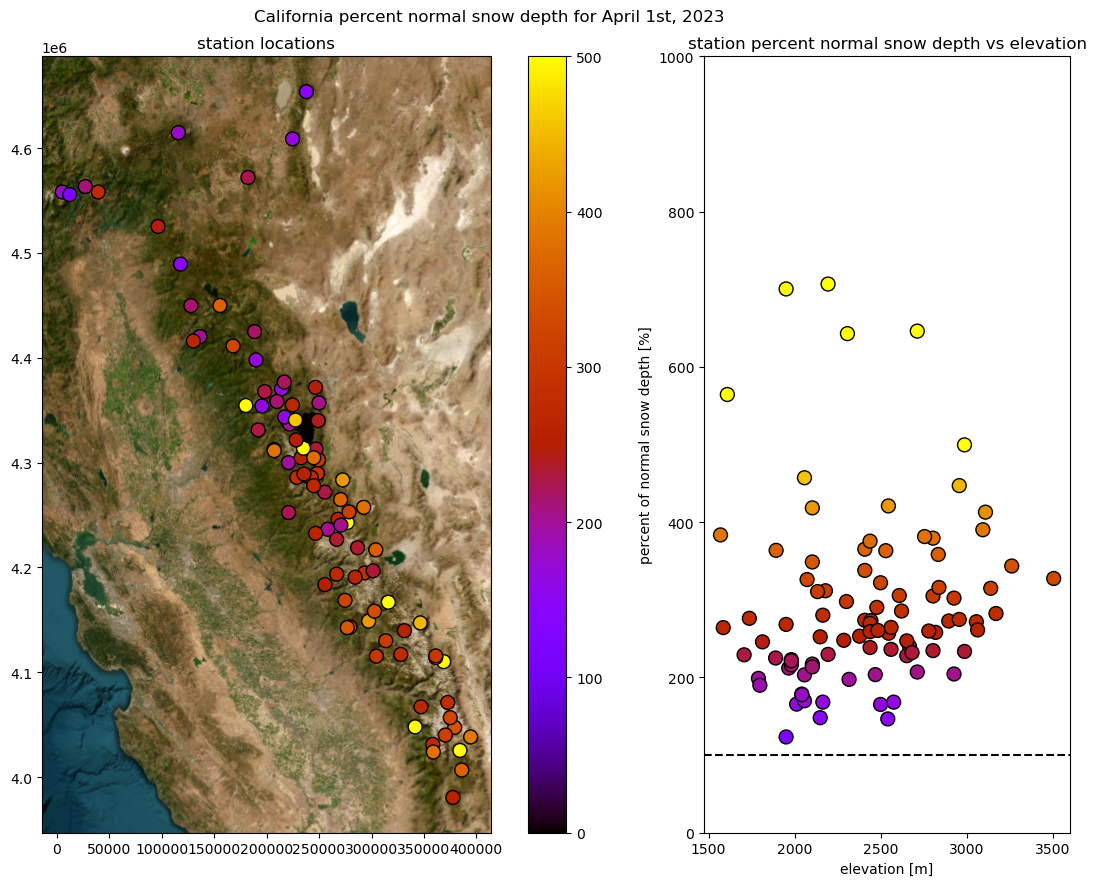

In [36]:
f, ax = plt.subplots(1, 2, figsize=(12, 9), gridspec_kw={"width_ratios": [2, 1]})

ccssStations.stations_gdf.to_crs("EPSG:32611").plot(
    ax=ax[0],
    column="april2023_percent_norm",
    legend=True,
    vmin=0,
    vmax=500,
    cmap="gnuplot",
    edgecolor="black",
    s=100,
)

ctx.add_basemap(
    ax[0], crs="EPSG:32611", source=ctx.providers.Esri.WorldImagery, attribution=""
)

ax[0].set_title("station locations")


ax[1].scatter(
    ccssStations.stations_gdf.elevation_m,
    ccssStations.stations_gdf.april2023_percent_norm,
    c=ccssStations.stations_gdf.april2023_percent_norm,
    cmap="gnuplot",
    vmin=0,
    vmax=500,
    edgecolors="black",
    s=100,
)
ax[1].axhline(y=100, linestyle="--", color="black")

ax[1].set_title("station percent normal snow depth vs elevation")
ax[1].set_xlabel("elevation [m]")
ax[1].set_ylabel("percent of normal snow depth [%]")

ax[1].set_ylim([0, 1000])

f.suptitle(f"California percent normal snow depth for April 1st, 2023")
f.tight_layout()

**Looks like a lot more snow than usual to me!**

## Read a variable from all CSVs by looping over the entire geodataframe: *Has the date of maximum SWE changed in the Western US?*
- [Snowmelt timing can be an important indicator of regional climate change](https://www.epa.gov/climate-indicators/climate-change-indicators-snowpack), and the snowmelt timing of the Western U.S. is projected to shift earlier in the year by up to 1 month by 2050 ([Barnett et al., 2005](https://www.nature.com/articles/nature04141); [Stewart, 2009](https://onlinelibrary.wiley.com/doi/10.1002/hyp.7128)), with a corresponding snowpack loss equivalent to a 25% decrease in streamflow from snowmelt ([Siirila-Woodburn et al., 2021](https://www.nature.com/articles/s43017-021-00219-y)).  
- Let's explore trends in maximum SWE timing using SNOTEL and CCSS stations

### This time we will get SWE at every station
- might take a minute to load in almost 1000 CSVs...
- store SWE for all stations in `all_stations_swe_df`

In [37]:
%%time 

WesternUS = easysnowdata.automatic_weather_stations.StationCollection()
WesternUS.get_data(WesternUS.all_stations_gdf,variables="WTEQ")

Geodataframe with all stations has been added to the Station object. Please use the .all_stations attribute to access.
Use the .get_data(stations=geodataframe/string/list,variables=string/list,start_date=str,end_date=str) method to fetch data for specific stations and variables.


100%|██████████| 969/969 [08:08<00:00,  1.98it/s]


WTEQ dataframe has been added to the Station object. Please use the .WTEQ_df attribute to access the data.
Full ['WTEQ'] dataset has been added to the station object. Please use the .data_ds attribute to access.
If you prefer to work with pandas dataframes instead of xarray datasets, please use the respective .variable_df attribute.
CPU times: user 15.1 s, sys: 1.59 s, total: 16.7 s
Wall time: 8min 13s


In [39]:
all_stations_swe_df = WesternUS.WTEQ
all_stations_swe_df

301_CA_SNTL  907_UT_SNTL  916_MT_SNTL  1267_AK_SNTL  908_WA_SNTL  \
datetime                                                                       
1909-04-13          NaN          NaN          NaN           NaN          NaN   
1954-12-01          NaN          NaN          NaN           NaN          NaN   
1954-12-02          NaN          NaN          NaN           NaN          NaN   
1954-12-03          NaN          NaN          NaN           NaN          NaN   
1954-12-04          NaN          NaN          NaN           NaN          NaN   
...                 ...          ...          ...           ...          ...   
2024-03-27       0.3708       0.3023       0.3048        0.2540       0.8661   
2024-03-28       0.4039       0.3023       0.3073        0.2515       0.8814   
2024-03-29       0.4267       0.3023       0.3175        0.2464       0.8839   
2024-03-30       0.4318       0.2692       0.3175        0.2464       0.8865   
2024-03-31       0.4318       0.2769       0.3200        0.2692       0.8865   

            1189_AK_SNTL  1062_AK_SNTL  1070_AK_SNTL  302_OR_SNTL  \
datetime                                                            
1909-04-13           NaN           NaN           NaN          NaN   
1954-12-01           NaN           NaN           NaN          NaN   
1954-12-02           NaN           NaN           NaN          NaN   
1954-12-03           NaN           NaN           NaN          NaN   
1954-12-04           NaN           NaN           NaN          NaN   
...                  ...           ...           ...          ...   
2024-03-27        0.1448        0.3226        0.3073       0.3785   
2024-03-28        0.1448        0.3251        0.3150       0.3886   
2024-03-29        0.1448        0.3277        0.3175       0.3937   
2024-03-30        0.1448        0.3226        0.3175       0.3962   
2024-03-31        0.1448        0.3327        0.3302       0.3988   

            1000_OR_SNTL  ...  QUA     LLP     FOR  GEM     WTM     SLT  \
datetime                  ...                                             
1909-04-13           NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN   
1954-12-01           NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN   
1954-12-02           NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN   
1954-12-03           NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN   
1954-12-04           NaN  ...  NaN     NaN     NaN  NaN     NaN     NaN   
...                  ...  ...  ...     ...     ...  ...     ...     ...   
2024-03-27        1.0897  ...  NaN  2.3995  0.4359  NaN  0.5715  0.9876   
2024-03-28        1.1176  ...  NaN  2.4514  0.4470  NaN  0.5817  0.9997   
2024-03-29        1.1354  ...  NaN  2.4755  0.4846  NaN  0.5893  1.0119   
2024-03-30        1.1379  ...  NaN  2.5098     NaN  NaN  0.6017  1.0363   
2024-03-31        1.1379  ...  NaN  2.5240     NaN  NaN  0.6078  1.0516   

               SLI     SLK     STL     TMR  
datetime                                    
1909-04-13     NaN     NaN     NaN     NaN  
1954-12-01     NaN     NaN  0.0635     NaN  
1954-12-02     NaN     NaN  0.0635     NaN  
1954-12-03     NaN     NaN  0.0635     NaN  
1954-12-04     NaN     NaN  0.1143     NaN  
...            ...     ...     ...     ...  
2024-03-27  0.7694  0.3063  0.5941  0.7381  
2024-03-28  0.8016  0.3094  0.6002  0.7442  
2024-03-29  0.8110  0.3155  0.6106  0.7503  
2024-03-30  0.8364  0.3338  0.6243  0.7777  
2024-03-31  0.8407  0.3399  0.6314  0.7930  

[23840 rows x 969 columns]

### Prepare the data
- prepare and clean `all_stations_swe_df`:
    - filter to start in WY 1967 (the first year with more than one station) and end with WY 2023
    - add water year column
    - remove any negative SWE measurements
    - for consistency with similar analyses, following the methodology of [Evan 2019](https://journals.ametsoc.org/view/journals/apme/58/1/jamc-d-18-0150.1.xml) and [US EPA 2021](https://www.epa.gov/sites/default/files/2021-04/documents/snowpack_td.pdf):
       - set any change of greater magnitude than 20cm to NaN
       - if there are more than 30 days of missing data during November-April, don't use that water year
       - if SWE is zero during every day of Jan/Feb/March, don't use that water year
       - only use stations with continuous data from WY 1982 
           - i do this only for the all data bulk calculation so we have a common reference frame, but for station level analysis i instead impose a 30 year or longer record rule

In [ ]:
all_stations_swe_df = all_stations_swe_df.loc[slice("1966-10-01", "2023-09-30")]

In [ ]:
all_stations_swe_df["WY"] = all_stations_swe_df.index.map(easysnowdata.utils.datetime_to_WY)

In [ ]:
all_stations_swe_df = all_stations_swe_df[all_stations_swe_df >= 0]

In [ ]:
all_stations_swe_diff_df = all_stations_swe_df.diff().abs()
all_stations_swe_df[all_stations_swe_diff_df > 0.20] = np.nan

In [ ]:
def check_missing_data(group):
    nov_to_apr_mask = group.index.month.isin([11, 12, 1, 2, 3, 4])
    filtered_group = group[nov_to_apr_mask]
    missing_data_counts = filtered_group.isnull().sum()
    columns_to_nan = missing_data_counts[missing_data_counts > 30].index
    group[columns_to_nan] = np.nan
    return group


def check_zero_swe(group):
    for month in [1, 2, 3]:
        month_mask = group.index.month == month
        zero_swe_columns = group[month_mask].eq(0).all()
        columns_to_nan = zero_swe_columns[zero_swe_columns].index
        group[columns_to_nan] = np.nan
    return group

In [ ]:
all_stations_swe_df = (
    all_stations_swe_df.groupby("WY").apply(check_missing_data).droplevel(0)
)
all_stations_swe_df = (
    all_stations_swe_df.groupby("WY").apply(check_zero_swe).droplevel(0)
)
all_stations_swe_df

### Calculate and plot trend in DOWY of max SWE for all data 
- use `DataFrame.groupby()` to find the date of max SWE per year and convert to a DOWY value, store in `all_stations_dowy_max_swe_df`
- calculate slope and intercept of linear regression using `np.polyfit()` on a melted version of  
- obtain statistics for each year using `DataFrame.describe()`

In [ ]:
all_stations_dowy_max_swe_df = (
    all_stations_swe_df.groupby("WY").idxmax().applymap(datetime_to_DOWY)
)

In [ ]:
stations_before_WY1982 = WesternUS.all_stations_gdf[WesternUS.all_stations_gdf.beginDate < "1981-10-01"]
dowy_max_swe_melted = pd.melt(
    all_stations_dowy_max_swe_df.reset_index(), id_vars="WY"
).dropna()
dowy_max_swe_melted_before_WY1982 = dowy_max_swe_melted[
    dowy_max_swe_melted["variable"].isin(stations_before_WY1982.index)
]
slope, intercept = np.polyfit(
    dowy_max_swe_melted_before_WY1982.WY, dowy_max_swe_melted_before_WY1982.value, 1
)
lr_years = np.unique(dowy_max_swe_melted.WY)

In [ ]:
describe = all_stations_dowy_max_swe_df.T.describe()
describe

In [ ]:
f, ax = plt.subplots(
    2, 1, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [3, 2]}
)

describe.loc["50%"].plot(ax=ax[0], label="median")

ax[0].fill_between(
    describe.columns, describe.loc["25%"], describe.loc["75%"], alpha=0.3, label="IQR"
)
ax[0].plot(
    lr_years,
    np.array(lr_years) * slope + intercept,
    "k--",
    label=f"Trend (slope={slope:.2f} Days/Year)",
)
# ax[0].set_xlim([1967,2023])

ax[0].legend()

describe.loc["count"].plot(ax=ax[1])


ax[0].set_title("Trend in DOWY of max SWE")
ax[1].set_title("Number of active stations")

### Check out trend at each station seperately
- calculate the linear trend in DOWY of max SWE only for stations with over 30 years of data, store in our original `all_stations_gdf`
    - out of 971 stations with SWE data, 645 meet this criteria
- plot the trend for each station and plot the trends on a histogram

In [ ]:
all_stations_gdf.loc[:, "dowy_max_swe_trend"] = all_stations_dowy_max_swe_df.apply(
    lambda y: (
        np.polyfit(y.dropna().index.values, y.dropna(), 1)[0]
        if len(y.dropna()) >= 30
        else np.nan
    )
)

In [ ]:
f, ax = plt.subplots(figsize=(10, 5.5))

WesternUS.all_stations_gdf.plot(
    column="dowy_max_swe_trend",
    ax=ax,
    legend=True,
    cmap="RdBu_r",
    edgecolor="k",
    markersize=20,
    vmin=-1,
    vmax=1,
    legend_kwds={"label": "[days/year]\n(Red is later in the year, blue is earlier)"},
)

ctx.add_basemap(
    ax, crs="EPSG:4326", source=ctx.providers.Esri.WorldImagery, attribution=""
)

ax.set_title("Trend in DOWY of max SWE\n(only stations with 30+ years of data)")

In [ ]:
f, ax = plt.subplots()

ax.hist(WesternUS.all_stations_gdf["dowy_max_swe_trend"], bins=50)

ax.axvline(x=0, color="red")

ax.set_xlim([-1.5, 1.5])

ax.set_xlabel("trend [days/year]")
ax.set_ylabel("count")
ax.set_title("Distribution of trends in DOWY of max SWE")

### Let's analyze these trends by mountain range
- we can `DataFrame.groupby()` our geodataframe by mountain range to calculate mountain range specific stats, store in `mountain_range_trend_df`
- mountain ranges with more stations (and more spatial coverage) are probably more trustworthy

In [ ]:
mountain_range_count = (
    WesternUS.all_stations_gdf.dropna().groupby("mountainRange")["dowy_max_swe_trend"].count()
)
mountain_range_median = (
    WesternUS.all_stations_gdf.dropna().groupby("mountainRange")["dowy_max_swe_trend"].median()
)
mountain_range_mean = (
    WesternUS.all_stations_gdf.dropna().groupby("mountainRange")["dowy_max_swe_trend"].mean()
)
mountain_range_std = (
    WesternUS.all_stations_gdf.dropna().groupby("mountainRange")["dowy_max_swe_trend"].std()
)

In [ ]:
mountain_range_trend_df = pd.concat(
    [
        mountain_range_count,
        mountain_range_median,
        mountain_range_mean,
        mountain_range_std,
    ],
    axis=1,
)
mountain_range_trend_df.columns = ["station_count", "median", "mean", "std"]

In [ ]:
mountain_range_trend_df

In [ ]:
f, ax = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 3]})

mountain_range_trend_df["station_count"].plot.barh(ax=ax[0])
mountain_range_trend_df["median"].plot.barh(ax=ax[1], cmap="RdBu")


ax[0].set_xlabel("[#]")
ax[1].set_xlabel("[days/year]")
ax[0].set_ylabel("")
ax[0].set_title("station count")
ax[1].set_title("trend")

f.suptitle("Trend in DOWY of max SWE by mountain range")

### Let's visualize this on a map 
- add spatial information to `mountain_range_trend_df` using `DataFrame.join()` with mountain range geometries from [GMBA Mountain Inventory v2](https://www.earthenv.org/mountains)
- ceate both a static plot with counts and medians and create an interactive plot so we can explore the trends across mountain ranges and stations

In [ ]:
url = (
    f"https://data.earthenv.org/mountains/standard/GMBA_Inventory_v2.0_standard_300.zip"
)
gmba_gdf = gpd.read_file("zip+" + url)

In [ ]:
mountain_range_trend_gdf = gpd.GeoDataFrame(
    mountain_range_trend_df.join(gmba_gdf[["MapName", "geometry"]].set_index("MapName"))
)

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14, 7))

mountain_range_trend_gdf.plot(
    ax=ax[0],
    column="station_count",
    vmin=0,
    vmax=100,
    cmap="viridis",
    legend=True,
    edgecolor="k",
    legend_kwds={"label": "[#]"},
)
mountain_range_trend_gdf.plot(
    ax=ax[1],
    column="median",
    vmin=-0.3,
    vmax=0.3,
    cmap="RdBu_r",
    legend=True,
    edgecolor="k",
    legend_kwds={"label": "[days/year]\n(Red is later in the year, blue is earlier)"},
)

for axs in ax:
    ctx.add_basemap(
        ax=axs,
        crs=mountain_range_trend_gdf.crs,
        source=ctx.providers.Esri.WorldImagery,
        attribution=False,
    )
    ctx.add_basemap(
        ax=axs,
        crs=mountain_range_trend_gdf.crs,
        source=ctx.providers.Esri.WorldImagery,
        attribution=False,
    )
    axs.set_xlim([-125, -104])
    axs.set_ylim([27, 55])

ax[0].set_title("count")
ax[1].set_title("trend")

f.suptitle(
    "Trend in DOWY of max SWE by mountain range\n(only stations with 30+ years of data)"
)

In [ ]:
m = mountain_range_trend_gdf.explore(
    column="median", cmap="RdBu_r", vmin=-0.5, vmax=0.5
)
WesternUS.all_stations_gdf.astype(dict(beginDate=str, endDate=str)).explore(
    m=m, column="dowy_max_swe_trend", cmap="RdBu_r", vmin=-0.3, vmax=0.3
)

**Looks like these trends are different by region, but relatively consistent within region. The majority of regions show the timing of maximum SWE happening earlier in the year, with notable exceptions being mountain ranges in the Pacific Northwest which show a reverse trend with smaller magnitude. Also of importance is the number of stations and their spatial dsitribution in each region, as 2 of the 4 regions (Olympic Mountains and Oregon Coast Range) showing the timing of maximum SWE happening later in the year only have one station each with a 30+ year record.**

## What if we want to check out all available daily variables at all SNOTEL and CCSS stations for all time?
- Let's check the data out as an xarray object!

In [ ]:
AllStations = easysnowdata.automatic_weather_stations.StationCollection()

In [ ]:
AllStations.get_entire_data_archive()

In [ ]:
stations.entire_data_archive_ds